# Import data and libs

In [1]:
!pip install PySastrawi
# !pip install CatBoost

In [2]:
!pip install indoNLP

In [1]:
import os
import re
import pickle
import nltk, string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from indoNLP.preprocessing import *
from tqdm.notebook import tqdm

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [3]:
# Configs
SEED = 42

# Data Kaggle

In [4]:
df = pd.read_csv('dataset/KaggleReview.csv')

In [5]:
df.head()

,Product,UserName,SkinCond_Age,Recommend,PostDate,Review,Rating
0,Perfect 3D Gel,MALA_,35 - 39,MALA_ recommends this product!,12 Jul 2020,Di aku beneran kerja. Melembabkan bgt. Tp gak ...,5
1,Perfect 3D Gel,Vitamaylinda,"Normal, 19 - 24",Vitamaylinda doesn't recommend this product!,31 May 2020,ga cocok bgttt bikin muka bruntusan dan lgsg m...,2
2,Perfect 3D Gel,aishdwie,"Combination, 19 - 24",aishdwie doesn't recommend this product!,30 Jul 2020,[SOLD]baru pertama kali nyoba dan beli karna l...,2
3,Perfect 3D Gel,ilmisaptiah,"Dry, 30 - 34",ilmisaptiah doesn't recommend this product!,12 Jul 2020,"enak sih di mukaku, yg tadinya kering jd lemba...",3
4,Perfect 3D Gel,alvinadin,"Oily, 19 - 24",alvinadin recommends this product!,15 Jul 2020,"SOLD OUT [PRELOVED] Halo aku preloved ini ya, ...",3


In [6]:
print('Before removing duplicates:', df.shape)
df = df.drop_duplicates(keep=False, ignore_index=True)
print('After removing duplicates:', df.shape)

Before removing duplicates: (8646, 7)
After removing duplicates: (8375, 7)


In [7]:
df = df[['Review', 'Rating']]

In [8]:
df.groupby(['Rating']).count()

,Review
Rating,
1,268
2,644
3,1490
4,2592
5,3381


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8375 entries, 0 to 8374
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  8375 non-null   object
 1   Rating  8375 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 131.0+ KB


In [10]:
def ratingToSentiment(row):
  sentiment = -1
  # print(row, row['Review'])
  if (row['Rating'] <= 2):
    sentiment = 0
  elif (row['Rating'] == 3):
    sentiment = 1
  else:
    sentiment = 2
  return sentiment

df['Sentiment'] = df.apply(ratingToSentiment, axis=1)

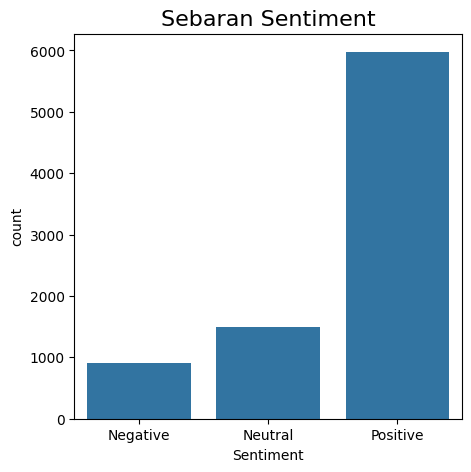

In [11]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x="Sentiment")
plt.title("Sebaran Sentiment", fontsize=16)
plt.xticks([0, 1, 2], ["Negative", "Neutral", "Positive"])
plt.show()

# Data Preprocessing

In [12]:
def get_stopwords(file_path):
  stopwords=[]
  file_stopwords = open(file_path,'r')
  row = file_stopwords.readline()
  while row:
      word = row.strip()
      stopwords.append(word)
      row = file_stopwords.readline()
  file_stopwords.close()
  return stopwords

def handle_stopwords(review, stopwords):
  feature_vector = []
  review = review.split(' ')
  for word in review:
    val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", word) #menghilangkan karakter selain huruf didalam kata
    if (word in stopwords or val is None):
      continue
    else:
      feature_vector.append(word)
  for_stemming = ' '.join(feature_vector)
  return feature_vector, for_stemming

In [13]:
# Remove emoji, punctuation, symbol
def preprocess(text):
  # Casefolding to Lowercase
  text = text.lower()

  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))

  text = replace_word_elongation(text)  # replace WE

  # Change emoji to words
  text = emoji_to_words(text)
  text = text.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))

  # Remove HTML tags
  text = remove_html(text) 
  text = remove_url(text)  # remove url
  text = replace_slang(text)  # replace slang words

  file_path ='dataset-classification/stopwords-indo.txt'
  stopwords = get_stopwords(file_path)
  feature, text = handle_stopwords(text, stopwords)

  # Remove numbers
  text = text.translate(str.maketrans('', '', string.digits))
  # Remove whitespaces at front and back
  text = ' '.join(text.split())

  # Stemming
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  text = stemmer.stem(text)
  return text


In [14]:
df["Cleaned"] = [preprocess(x) for x in tqdm(df['Review'].values)]

  0%|          | 0/8375 [00:00<?, ?it/s]

In [15]:
data = df

In [16]:
data.head()

,Review,Rating,Sentiment,Cleaned
0,Di aku beneran kerja. Melembabkan bgt. Tp gak ...,5,2,benar kerja melembabkan banget enggak lebaygak...
1,ga cocok bgttt bikin muka bruntusan dan lgsg m...,2,0,enggak cocok banget bikin muka bruntusan langs...
2,[SOLD]baru pertama kali nyoba dan beli karna l...,2,0,soldbaru kali coba beli lihat yt famaledaily p...
3,"enak sih di mukaku, yg tadinya kering jd lemba...",3,1,enak sih muka kering lembab pagi bangun kenyal...
4,"SOLD OUT [PRELOVED] Halo aku preloved ini ya, ...",3,1,sold out preloved halo preloved ya pakai mingg...


In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=6000)
x = vectorizer.fit_transform(data['Cleaned'].values)
x

<8375x6000 sparse matrix of type '<class 'numpy.float64'>'
	with 266032 stored elements in Compressed Sparse Row format>

# WordCloud

In [19]:
nama_fitur = vectorizer.get_feature_names_out()
index_p = data["Cleaned"][data["Sentiment"] == 2].index
index_n = data["Cleaned"][data["Sentiment"] == 0].index
positif = x[index_p]
negatif = x[index_n]

In [20]:
def finder(words):
    top_kata = {}
    for i in range(words.shape[0]):
        row = words.getrow(i).toarray()[0]
        max_ = np.argmax(row)
        if nama_fitur[max_] in top_kata:
            top_kata[nama_fitur[max_]] += 1
        else:
            top_kata[nama_fitur[max_]] = 1
    return top_kata

top_positif = finder(positif)
top_negatif = finder(negatif)

In [21]:
# Sorting
top_positif = {k: v for k, v in sorted(top_positif.items(), key=lambda item: item[1], reverse=True)}
top_negatif = {k: v for k, v in sorted(top_negatif.items(), key=lambda item: item[1], reverse=True)}

In [22]:
from wordcloud import WordCloud

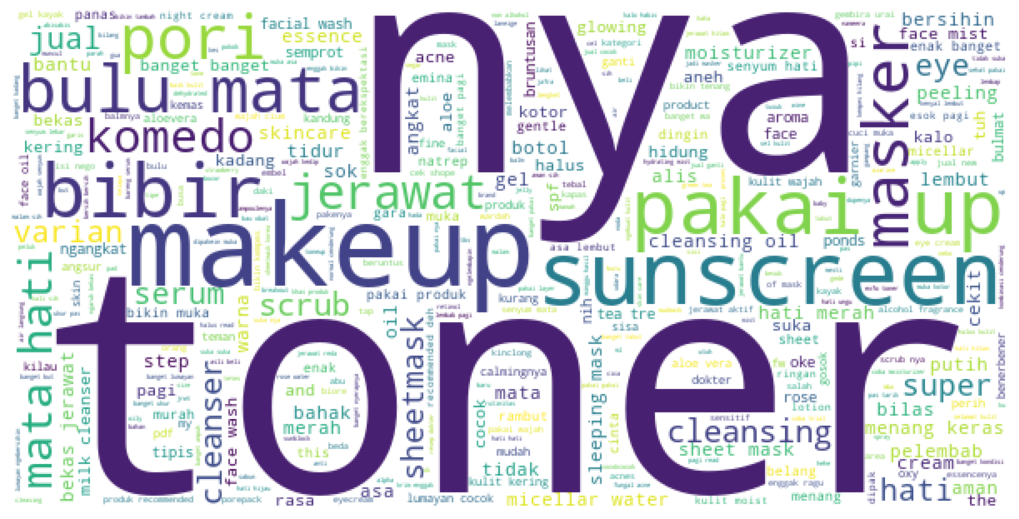

In [23]:
# WordCloud kata dengan bobot terbesar Positif
w = WordCloud(
    width=600,
    height=300,
    colormap="viridis",
    mode="RGBA",
    stopwords=STOPWORDS,
    background_color="white",
    max_words=5000,
    random_state=SEED,
).fit_words(top_positif)

plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(w)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

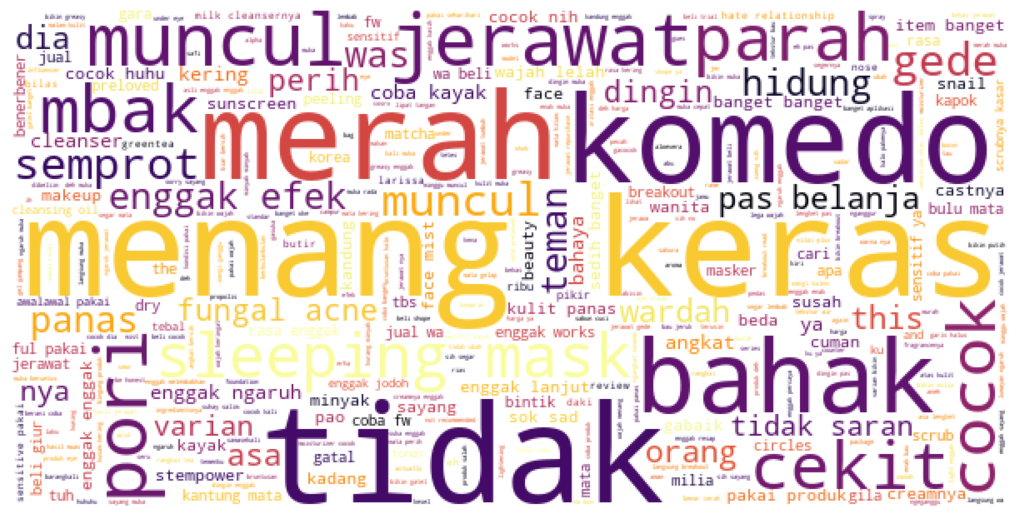

In [24]:
# Negatif
w = WordCloud(
    width=600,
    height=300,
    mode="RGBA",
    stopwords=STOPWORDS,
    colormap="inferno",
    background_color="white",
    max_words=5000,
).fit_words(top_negatif)

plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(w)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [25]:
y = data['Sentiment']

In [26]:
# Test combination sampling to handle imbalance data
from imblearn.combine import SMOTEENN
from collections import Counter

print('Initial:', Counter(data['Sentiment']))

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
x_resampled, y_resampled = smote_tomek.fit_resample(x, data['Sentiment'])
print('SMOTE TOMEK:', sorted(Counter(y_resampled).items()))
# [(0, 1540), (1, 1559), (2, 1542)] 

Initial: Counter({2: 5973, 1: 1490, 0: 912})
SMOTE ENN: [(0, 5610), (1, 5237), (2, 82)]
SMOTE TOMEK: [(0, 5973), (1, 5973), (2, 5973)]


# Data Modeling

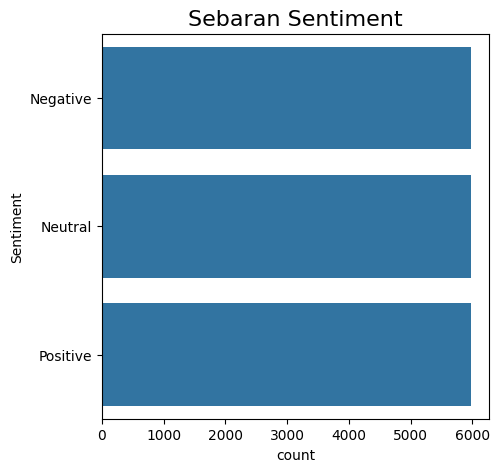

In [27]:
# Pasca imbalance
plt.figure(figsize=(5, 5))
sns.countplot(y=y_resampled)
plt.title("Sebaran Sentiment", fontsize=16)
plt.yticks([0, 1, 2], ["Negative", "Neutral", "Positive"])
# plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()


# Choosing Model

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [31]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import LinearSVC

In [29]:
# Model after the Data Augmentation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

classifiers = {
    "Decision Tree Classifier ": DecisionTreeClassifier(random_state=SEED),
    "Logistic Regression      ": LogisticRegression(random_state=SEED),
    "Random Forest Classifier ": RandomForestClassifier(random_state=SEED),
    "SVM                      ": SVC(probability=True, random_state=SEED), #dikomen dulu karena lama
}

x = x_resampled
y = y_resampled

for name, clf in classifiers.items():
    scores = cross_val_score(clf, x, y, cv=cv)
    print(f"Rata - rata akurasi dari {name} : {scores.mean():.4f} - std : {scores.std():.4f}")

Rata - rata akurasi dari Decision Tree Classifier  : 0.7432 - std : 0.0051
Rata - rata akurasi dari Logistic Regression       : 0.8492 - std : 0.0056
Rata - rata akurasi dari Random Forest Classifier  : 0.9142 - std : 0.0036
Rata - rata akurasi dari SVM                       : 0.9223 - std : 0.0054


In [32]:
scores = cross_val_score(OneVsOneClassifier(LinearSVC(random_state=0)), x, y, cv=cv)
print(f"Rata - rata akurasi dari SVM OneVsOne : {scores.mean():.4f} - std : {scores.std():.4f}")

Rata - rata akurasi dari SVM OneVsOne : 0.9033 - std : 0.0043


In [33]:
scores = cross_val_score(OneVsRestClassifier(LinearSVC(random_state=0)), x, y, cv=cv)
print(f"Rata - rata akurasi dari SVM OneVsRest : {scores.mean():.4f} - std : {scores.std():.4f}")

Rata - rata akurasi dari SVM OneVsRest : 0.8980 - std : 0.0041


# Hyperparameter Tuning

# Splitting Data

In [34]:
x = x_resampled
y = y_resampled

In [201]:
x.shape

(17919, 6000)

In [202]:
y.shape

(17919,)

In [35]:
x_train, x_test, y_train, y_test = train_test_split(
  x,
  y,
  test_size=0.2,
  random_state=SEED,
)

# Building Model

In [36]:
# model = LogisticRegression(random_state=SEED)
model = RandomForestClassifier(random_state=SEED)

In [37]:
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [64]:
import joblib
joblib.dump(model, 'Skincare-Sentiment-Analysis.joblib')
# model.save('Skincare-Sentiment-Analysis.h5')

['Skincare-Sentiment-Analysis.joblib']

In [65]:
joblib.dump(vectorizer, 'skincare-vectorizer.pkl')

['skincare-vectorizer.pkl']

In [38]:
result = model.predict(x_test)

Confusion Matrix:



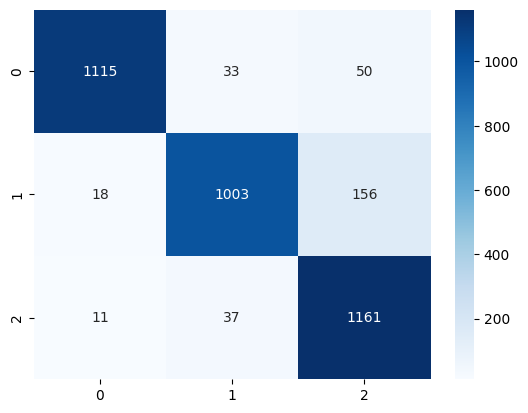

%Accuracy 0.9148995535714286


In [39]:
from sklearn.metrics import confusion_matrix
res = confusion_matrix(y_test, result)
bener = sum(y_test==result)
print('Confusion Matrix:\n')
sns.heatmap(res, annot=True, fmt="d", cmap="Blues")
plt.show()
print('%Accuracy', bener/len(y_test))
# Random Forest

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1198
           1       0.93      0.85      0.89      1177
           2       0.85      0.96      0.90      1209

    accuracy                           0.91      3584
   macro avg       0.92      0.91      0.92      3584
weighted avg       0.92      0.91      0.92      3584



# Console-Based Program

In [60]:
# user_txt = input('Type your review: ')
user_txt = [
  "Keren, jerawatku hilang dalam pemakaian rutin",
  "Bagus, beneran ngaruh di aku",
  "Sejauh ini sih belum kelihatan hasilnya",
  "Belum kelihatan hasilnya",
  "Ga rekomen sih",
  "Jelek banget",
  "Jelekk, di aku bikin jerawatan",
  "Nggak cocok di aku, bikin jerawatan. gak worth it",
  "Nggak cocok di kulitku",
  "pas dipake terasa cekit, terus kulit jadi merah",
]
for i in range (len(user_txt)):
  user_txt[i] = preprocess(user_txt[i])
  print(user_txt[i])
user_tf = vectorizer.transform(user_txt)
user_tf.shape

# # Mendapatkan feature names (kata-kata yang di-vectorize)
# feature_names = vectorizer.get_feature_names_out()

# # Mendapatkan TF-IDF scores dari input pengguna
# user_tfidf_scores = user_tf.toarray()

# # Tampilkan hasil dalam bentuk DataFrame untuk memudahkan pembacaan
# tfidf_df = pd.DataFrame(user_tfidf_scores, columns=feature_names)

# # Transpos DataFrame agar kata-kata menjadi index dan skor menjadi kolom
# tfidf_df_transposed = tfidf_df.T

# # Beri nama kolom untuk lebih jelas
# tfidf_df_transposed.columns = ['tfidf_score']

# # Sort DataFrame berdasarkan skor TF-IDF dari besar ke kecil
# sorted_tfidf_df = tfidf_df_transposed.sort_values(by='tfidf_score', ascending=False)

# # bakal ada feature yang nilainya 0, yaitu yang nggak ada di input user. ini ttp ada di vector karena supaya ukurannya sama dengan ukuran vector training
# print(sorted_tfidf_df)

keren jerawat hilang pakai rutin
bagus benar ngaruh
sih hasil
hasil
enggak rekomen sih
jelek banget
jelek bikin jerawat
enggak cocok bikin jerawat enggak worth
enggak cocok kulit
pas pakai cekit kulit merah


(10, 6000)

In [61]:
res_arr = model.predict(user_tf)

for res in res_arr:
  if (res == 2):
    print('Positif')
  elif (res == 1):
    print('Netral')
  else:
    print('Negatif')

# masih jelek x :(

Positif
Positif
Positif
Netral
Netral
Positif
Positif
Negatif
Negatif
Positif
